# Mortality Prediction using ensemble Model

## Read data

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


### Format data

In [2]:
dropCols = [
    'micro_specimen_id',
    'person_id',
    'seven_day_mortality',
    'fourteen_day_mortality',
    'twentyone_day_mortality',
    'twentyeight_day_mortality',
    'sixty_day_mortality',
    'ninety_day_mortality',
    'onetwenty_day_mortality',
    'Ambulatory Clinic / Center',
    'Ambulatory Surgical Center',
    'Emergency Room - Hospital',
    'Emergency Room and Inpatient Visit',
    'Inpatient Visit',
    'Observation Room',
    'AMBULATORY OBSERVATION',
    'DIRECT EMER.',
    'ELECTIVE',
    'EU OBSERVATION',
    'EW EMER.',
    'OBSERVATION ADMIT',
    'SURGICAL SAME DAY ADMISSION',
    'URGENT',
    'AMBULATORY SURGERY TRANSFER',
    'CLINIC REFERRAL',
    'EMERGENCY ROOM',
    'INFORMATION NOT AVAILABLE',
    'INTERNAL TRANSFER TO OR FROM PSYCH',
    'PACU',
    'PHYSICIAN REFERRAL',
    'PROCEDURE SITE',
    'TRANSFER FROM HOSPITAL',
    'TRANSFER FROM SKILLED NURSING FACILITY',
    'WALK-IN/SELF REFERRAL',
]

X = dataDf.drop(dropCols, axis = 1)
XVitalsMax = dataDf[['temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max']]
XVitalsMin = dataDf[['temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min']]
XVitalsAvg = dataDf[['temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg']]
XVitalsSd = dataDf[['temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd']]
XVitalsFirst = dataDf[['temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first']]
XVitalsLast = dataDf[['temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last']]
XLabsMax = dataDf[['potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max']]
XLabsMin = dataDf[['potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min']]
XLabsAvg = dataDf[['potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg']]
XLabsSd = dataDf[['potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd']]
XLabsFirst = dataDf[['potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first']]
XLabsLast = dataDf[['potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']]
ySevenDay = dataDf['seven_day_mortality']

In [3]:
X.shape, XVitalsMax.shape, XVitalsMin.shape, XVitalsAvg.shape, XVitalsSd.shape, XVitalsFirst.shape, XVitalsLast.shape, XLabsMax.shape, XLabsMin.shape, XLabsAvg.shape, XLabsSd.shape, XLabsFirst.shape, XLabsLast.shape, ySevenDay.shape

((7102, 134),
 (7102, 15),
 (7102, 15),
 (7102, 15),
 (7102, 15),
 (7102, 15),
 (7102, 15),
 (7102, 7),
 (7102, 7),
 (7102, 7),
 (7102, 7),
 (7102, 7),
 (7102, 7),
 (7102,))

## Function to calculate MCCF1 metric

In [4]:
import sys
import os

from sklearn.metrics import make_scorer

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# import R's "base" package
mccf1 = importr('mccf1')


def calculateMccF1(x, y):
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    p = robjects.FloatVector(x)
    t = robjects.FloatVector(y)
    calculateMccf1 = robjects.r['mccf1']
    summary = robjects.r['summary']
    out = summary(calculateMccf1(t, p), 50)[0][0]
    sys.stdout = old_stdout # reset old stdout
    return out

## First level models

### Split data to test and train sets

In [5]:
from sklearn.model_selection import train_test_split

XVitalsMaxTrain, XVitalsMaxTest, XVitalsMinTrain, XVitalsMinTest, XVitalsAvgTrain, XVitalsAvgTest, XVitalsSdTrain, XVitalsSdTest, XVitalsFirstTrain, XVitalsFirstTest, XVitalsLastTrain, XVitalsLastTest, XLabsMaxTrain, XLabsMaxTest, XLabsMinTrain, XLabsMinTest, XLabsAvgTrain, XLabsAvgTest, XLabsSdTrain, XLabsSdTest, XLabsFirstTrain, XLabsFirstTest, XLabsLastTrain, XLabsLastTest, ySevenDayTrain, ySevenDayTest = train_test_split(
    XVitalsMax,
    XVitalsMin,
    XVitalsAvg,
    XVitalsSd,
    XVitalsFirst,
    XVitalsLast,
    XLabsMax,
    XLabsMin,
    XLabsAvg,
    XLabsSd,
    XLabsFirst,
    XLabsLast,
    ySevenDay,
    test_size=0.2,
    random_state=42
)

### Tune hyperparameter

In [6]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [7]:
xgbParameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
}

xgbGrid = GridSearchCV(XGBClassifier(use_label_encoder=False, verbosity=0), xgbParameters)
xgbGrid.fit(XVitalsMax, ySevenDay)

xgbParams = xgbGrid.cv_results_['params'][list(xgbGrid.cv_results_['rank_test_score']).index(1)]
xgbParams

{'max_depth': 12, 'scale_pos_weight': 0.4}

In [8]:
lrParameters={
    'solver': ['newton-cg', 'liblinear'],
    'C': [100, 10, 1.0, 0.1, 0.01],
}

lrGrid = GridSearchCV(LogisticRegression(), lrParameters)
lrGrid.fit(XVitalsMax, ySevenDay)

lrParams = lrGrid.cv_results_['params'][list(lrGrid.cv_results_['rank_test_score']).index(1)]
lrParams

{'C': 0.1, 'solver': 'liblinear'}

### Build models and obtain predictions

In [9]:
XDict = {
    'VitalsMax': (XVitalsMaxTrain, XVitalsMaxTest),
    'VitalsMin': (XVitalsMinTrain, XVitalsMinTest),
    'VitalsAvg': (XVitalsAvgTrain, XVitalsAvgTest),
    'VitalsSd': (XVitalsSdTrain, XVitalsSdTest),
    'VitalsFirst': (XVitalsFirstTrain, XVitalsFirstTest),
    'VitalsLast': (XVitalsLastTrain, XVitalsLastTest),
    'LabsMax': (XLabsMaxTrain, XLabsMaxTest),
    'LabsMin': (XLabsMinTrain, XLabsMinTest),
    'LabsAvg': (XLabsAvgTrain, XLabsAvgTest),
    'LabsSd': (XLabsSdTrain, XLabsSdTest),
    'LabsFirst': (XLabsFirstTrain, XLabsFirstTest),
    'LabsLast': (XLabsLastTrain, XLabsLastTest),
}

probsDict = {}

for label, (XTrain, XTest) in XDict.items():

    xgb = XGBClassifier(use_label_encoder=False)
    xgb.set_params(**xgbParams)
    xgb.fit(XTrain, ySevenDayTrain)

    xgbProbs = [p2 for p1, p2 in xgb.predict_proba(XTest)]

    probsDict[('XGB', label)] = xgbProbs

    lr = LogisticRegression()
    lr.set_params(**lrParams)
    lr.fit(XTrain, ySevenDayTrain)

    lrProbs = [p2 for p1, p2 in lr.predict_proba(XTest)]

    probsDict[('LR', label)] = lrProbs

    lgbm = LGBMClassifier()
    lgbm.set_params(**xgbParams)
    lgbm.fit(XTrain, ySevenDayTrain)

    lgbmProbs = [p2 for p1, p2 in lgbm.predict_proba(XTest)]

    probsDict[('LGBM', label)] = lgbmProbs

    mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes = (200, 200))
    mlp.fit(XTrain, ySevenDayTrain)

    mlpProbs = [p2 for p1, p2 in mlp.predict_proba(XTest)]

    probsDict[('MLP', label)] = mlpProbs

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Aggregate the predictions

In [10]:
import pandas as pd

Xnew = pd.DataFrame()

for key, value in probsDict.items():
    Xnew[key[0] + '_' + key[1]] = value

Xnew

,XGB_VitalsMax,LR_VitalsMax,LGBM_VitalsMax,MLP_VitalsMax,XGB_VitalsMin,LR_VitalsMin,LGBM_VitalsMin,MLP_VitalsMin,XGB_VitalsAvg,LR_VitalsAvg,...,LGBM_LabsSd,MLP_LabsSd,XGB_LabsFirst,LR_LabsFirst,LGBM_LabsFirst,MLP_LabsFirst,XGB_LabsLast,LR_LabsLast,LGBM_LabsLast,MLP_LabsLast
0,0.001665,0.038319,0.005405,1.839353e-07,0.003798,0.045963,0.028228,2.486275e-17,0.000297,0.011335,...,0.042815,0.031600,0.038639,0.074100,0.113354,2.268563e-03,0.000823,0.132538,0.011044,5.459330e-07
1,0.000058,0.114482,0.006335,7.706281e-05,0.014205,0.101472,0.035483,1.591007e-06,0.020578,0.154067,...,0.018575,0.027545,0.000593,0.191210,0.015160,1.437998e-08,0.083316,0.221223,0.103375,6.805944e-03
2,0.006275,0.210841,0.043761,4.951207e-01,0.881394,0.187435,0.650697,4.002405e-02,0.262557,0.214054,...,0.588010,0.996534,0.965832,0.584574,0.807436,1.000000e+00,0.745715,0.047339,0.167900,9.901917e-01
3,0.002920,0.196302,0.036726,9.684761e-09,0.000314,0.035138,0.004243,5.368036e-11,0.006520,0.257209,...,0.019554,0.001299,0.005388,0.113453,0.052410,2.570708e-06,0.001793,0.085461,0.021429,1.359994e-02
4,0.001960,0.121798,0.024322,3.485471e-09,0.000935,0.237323,0.020846,8.991851e-08,0.000547,0.113289,...,0.051644,0.000063,0.010965,0.156805,0.050324,5.089313e-01,0.004142,0.163450,0.036843,1.678093e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,0.002255,0.128395,0.026047,2.353259e-05,0.000202,0.067798,0.001480,4.186104e-09,0.005007,0.153208,...,0.021154,0.002158,0.005380,0.155553,0.026516,5.503313e-03,0.000825,0.068079,0.008608,2.150366e-03
1417,0.983038,0.970147,0.916699,9.978178e-01,0.998254,0.904840,0.990137,1.000000e+00,0.983597,0.918715,...,0.831222,1.000000,0.988064,0.341504,0.911898,9.999906e-01,0.994310,0.992192,0.970792,1.000000e+00
1418,0.027355,0.156502,0.089282,2.768582e-08,0.000560,0.086001,0.014614,1.395302e-05,0.001518,0.120856,...,0.019814,0.000536,0.057123,0.100655,0.030733,1.820827e-02,0.001112,0.082411,0.007349,6.321437e-03
1419,0.000673,0.037315,0.001551,8.557997e-06,0.000210,0.021177,0.000699,9.454570e-15,0.000055,0.019951,...,0.065846,0.889445,0.004184,0.097017,0.009289,1.320596e-04,0.004624,0.052571,0.008879,6.228844e-05


## Second level

### Feature selection

#### Tune hyperparameters for the estimator

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters={
    'n_neighbors': [3, 4, 5, 6, 7, 8],
    'weights' : ['uniform', 'distance'],
    'p': [1, 2, 3]
}

clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(Xnew, ySevenDayTest)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

#### Perform SFS

In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.set_params(**params)

sfs1 = SFS(estimator = knn,
           k_features=48,
           forward=True,
           floating=True,
           scoring='accuracy',
           cv=5)

sfs1.fit(Xnew, ySevenDayTest)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3, p=1,
                                                         weights='distance'),
                          floating=True, k_features=48, scoring='accuracy')

In [13]:
labels = []
cv_scores = []
for key, value in sfs1.subsets_.items():
    labels.append(key)
    cv_scores.append(value['cv_scores'])

[Text(0, 0.5, 'Model Accuracy')]

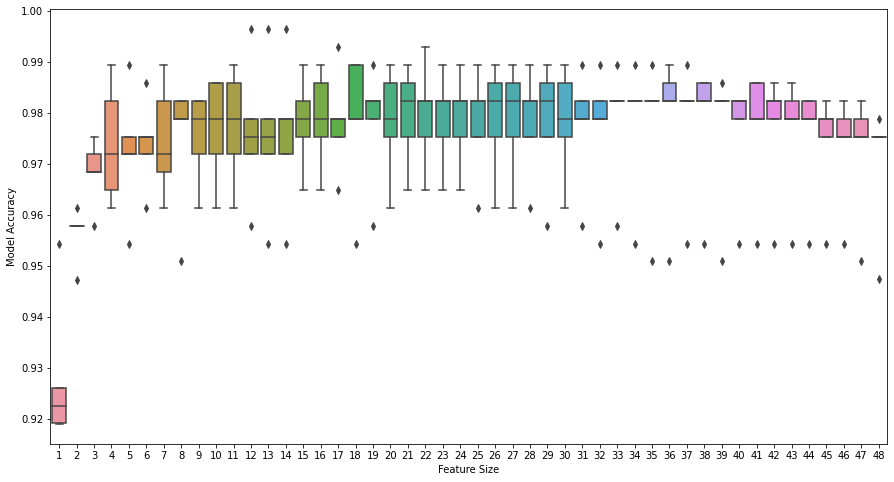

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=cv_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Accuracy')

### t-SNE

In [15]:
from sklearn.manifold import TSNE

XTsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(Xnew)

In [16]:
import pandas as pd

tsneDf = pd.DataFrame(XTsne, columns = ['x', 'y'])
tsneDf['label'] = ySevenDayTest.to_list()

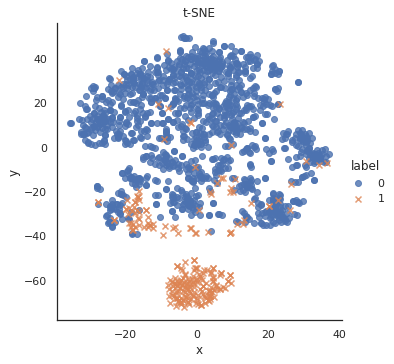

In [17]:
import seaborn as sns
import pandas as pd

sns.set(style="white", color_codes=True)
sns.lmplot( x="x", y="y", data=tsneDf, fit_reg=False, hue='label', markers=['o', 'x']).set(title='t-SNE')

### PCA

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(Xnew)

In [19]:
import pandas as pd

pcaDf = pd.DataFrame(pca, columns = ['x', 'y'])
pcaDf['label'] = ySevenDayTest.to_list()

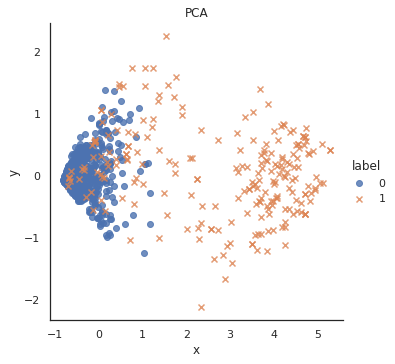

In [20]:
import seaborn as sns
import pandas as pd

sns.set(style="white", color_codes=True)
sns.lmplot( x="x", y="y", data=pcaDf, fit_reg=False, hue='label', markers=['o', 'x']).set(title='PCA')

### Split data to test and train sets

In [21]:
from sklearn.model_selection import train_test_split

XNewTrain, XNewTest, ySevenDayTestTrain, ySevenDayTestTest = train_test_split(Xnew, ySevenDayTest, test_size=0.2, random_state=42)

In [22]:
XNewTrain.shape, XNewTest.shape, ySevenDayTestTrain.shape, ySevenDayTestTest.shape

((1136, 48), (285, 48), (1136,), (285,))

### XGBoost

In [23]:
from xgboost import XGBClassifier

#### Tune hyperparameter

In [24]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(Xnew, ySevenDayTest)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

{'max_depth': 6, 'scale_pos_weight': 0.35}

#### Cross-validation

In [25]:
from sklearn.model_selection import cross_validate

xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=0.35, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)

In [26]:
xgb_scores = cross_validate(xgb, Xnew, ySevenDayTest, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, Xnew, ySevenDayTest, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

{'fit_time': array([0.23061705, 0.23311496, 0.23238564, 0.26055694, 0.22912288]),
 'score_time': array([0.01445293, 0.04026747, 0.01391292, 0.01422954, 0.01294541]),
 'test_accuracy': array([0.95789474, 0.97887324, 0.97535211, 0.98591549, 0.96478873]),
 'test_balanced_accuracy': array([0.88941534, 0.95232006, 0.94145049, 0.96529046, 0.90007307]),
 'test_average_precision': array([0.91761366, 0.98161394, 0.95874853, 0.97855751, 0.92800671]),
 'test_f1': array([0.86046512, 0.93333333, 0.92134831, 0.95555556, 0.88095238]),
 'test_roc_auc': array([0.96039692, 0.9955243 , 0.97488126, 0.99232737, 0.96008403]),
 'test_mccf1_score': array([0.88643811, 0.94522605, 0.93547824, 0.96350495, 0.9033906 ])}

#### Build Single Model

In [27]:
xgb.fit(XNewTrain, ySevenDayTestTrain)
xgb_prob = xgb.predict_proba(XNewTest)
xgb_pred = xgb.predict(XNewTest)

#### Performance metrics

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Accuracy: ', str(accuracy_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('Balanced Accuracy: ', str(balanced_accuracy_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('Average Precision: ', str(average_precision_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('F1: ', str(f1_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('MCC: ', str(matthews_corrcoef([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('AUROC: ', str(roc_auc_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))
print('MCCF1: ', str(calculateMccF1([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)))

Accuracy:  0.9719298245614035
Balanced Accuracy:  0.9555356469256884
Average Precision:  0.8410599126274183
F1:  0.9111111111111111
MCC:  0.8947657593157307
AUROC:  0.9555356469256883
MCCF1:  0.9269596141816052


#### ROC curve

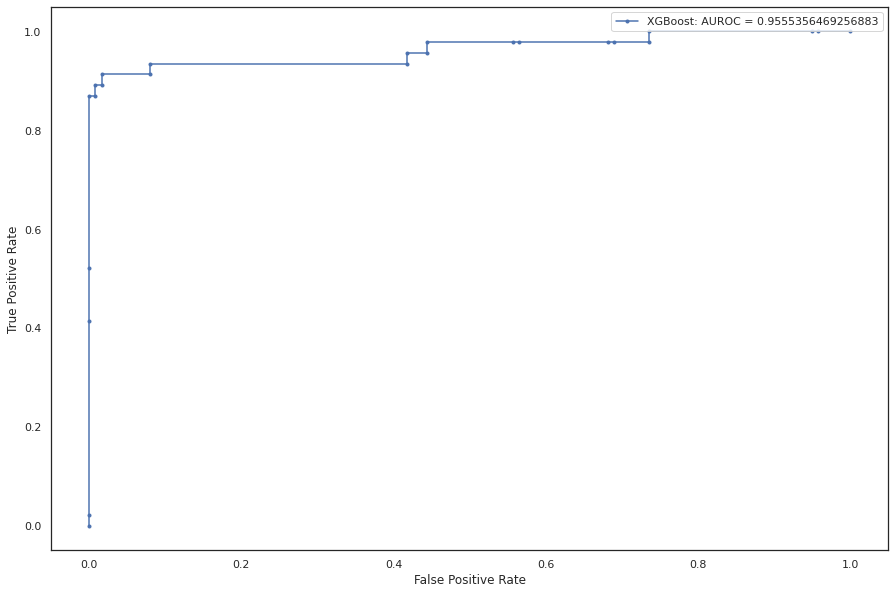

In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score([p2.round() for p1, p2 in xgb_prob], ySevenDayTestTest)

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (ySevenDayTestTest, xgb_prob, 'XGBoost: AUROC = ' + str(auc_score))
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Prediction probability distribution

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


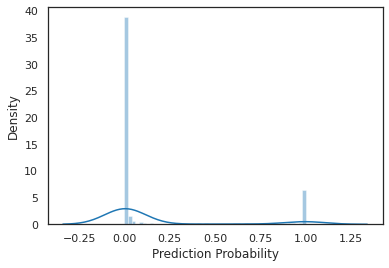

In [30]:
 import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
sns.distplot([p2 for p1, p2 in xgb_prob], hist=True, rug=False, color='tab:blue', axlabel='Prediction Probability')
plt.show()

#### Feature importance

<BarContainer object of 48 artists>

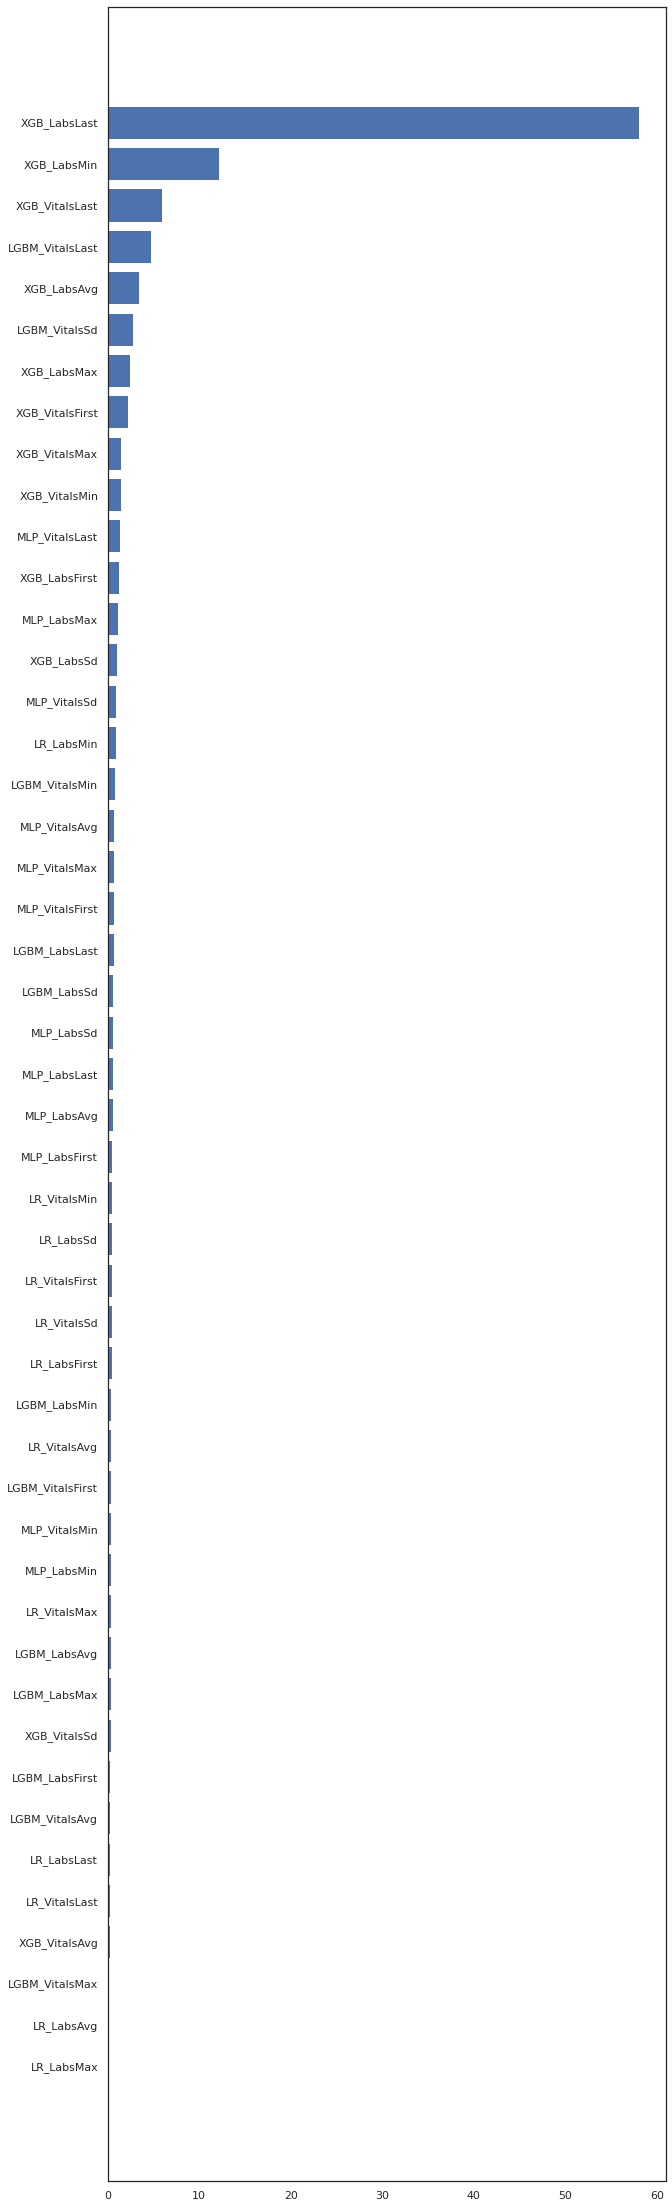

In [31]:
X_header = [x for x in XNewTest.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

#### Tune Hyperparameter

In [33]:
from sklearn.model_selection import GridSearchCV

parameters={
    'solver': ['newton-cg', 'liblinear'],
    'C': [100, 10, 1.0, 0.1, 0.01],
}

clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(Xnew, ySevenDayTest)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

#### Cross-validation

In [34]:
lr = LogisticRegression()
lr.set_params(**params)

LogisticRegression(solver='liblinear')

In [35]:
from sklearn.model_selection import cross_validate

lr_scores = cross_validate(lr, Xnew, ySevenDayTest, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
lr_scores['test_mccf1_score'] = cross_validate(lr, Xnew, ySevenDayTest, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
lr_scores

{'fit_time': array([0.01230955, 0.01096821, 0.01151323, 0.01179051, 0.01137137]),
 'score_time': array([0.0065546 , 0.00633383, 0.00636959, 0.00675631, 0.0063839 ]),
 'test_accuracy': array([0.95438596, 0.98239437, 0.97183099, 0.98239437, 0.96830986]),
 'test_balanced_accuracy': array([0.87877704, 0.9544209 , 0.93058093, 0.94565217, 0.90217391]),
 'test_average_precision': array([0.92296796, 0.97625925, 0.95052185, 0.9858471 , 0.91628419]),
 'test_f1': array([0.84705882, 0.94382022, 0.90909091, 0.94252874, 0.89156627]),
 'test_roc_auc': array([0.96504559, 0.99251005, 0.9814578 , 0.99643771, 0.94208988]),
 'test_mccf1_score': array([0.87575752, 0.95395392, 0.92554762, 0.95319604, 0.91243258])}

#### Build single model

In [36]:
lr.fit(XNewTrain, ySevenDayTestTrain)

lr_prob = lr.predict_proba(XNewTest)
lr_pred = lr.predict(XNewTest)

#### Performance metrics

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Accuracy: ', str(accuracy_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('Balanced Accuracy: ', str(balanced_accuracy_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('Average Precision: ', str(average_precision_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('F1: ', str(f1_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('MCC: ', str(matthews_corrcoef([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('AUROC: ', str(roc_auc_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))
print('MCCF1: ', str(calculateMccF1([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)))

Accuracy:  0.9754385964912281
Balanced Accuracy:  0.9755097960815673
Average Precision:  0.8518650815798775
F1:  0.9195402298850575
MCC:  0.9071903862636773
AUROC:  0.9755097960815673
MCCF1:  0.9343220710305937


#### Roc curve

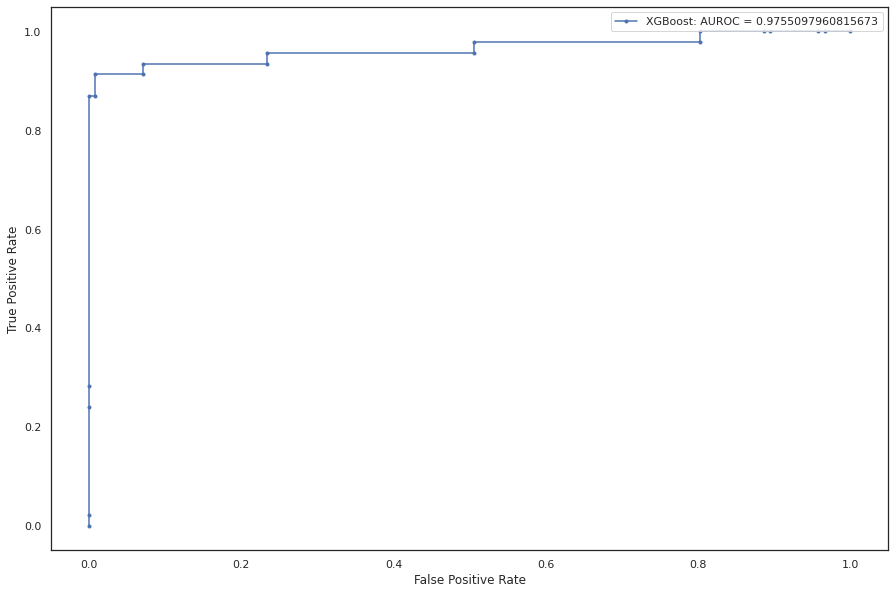

In [38]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score([p2.round() for p1, p2 in lr_prob], ySevenDayTestTest)

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (ySevenDayTestTest, lr_prob, 'XGBoost: AUROC = ' + str(auc_score))
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Prediction probability distribution

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


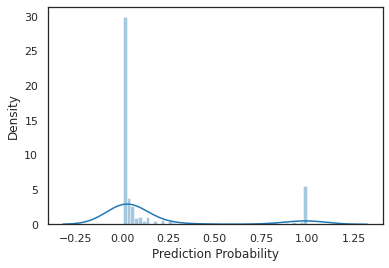

In [39]:
 import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
sns.distplot([p2 for p1, p2 in lr_prob], hist=True, rug=False, color='tab:blue', axlabel='Prediction Probability')
plt.show()

#### Feature Importance

<BarContainer object of 48 artists>

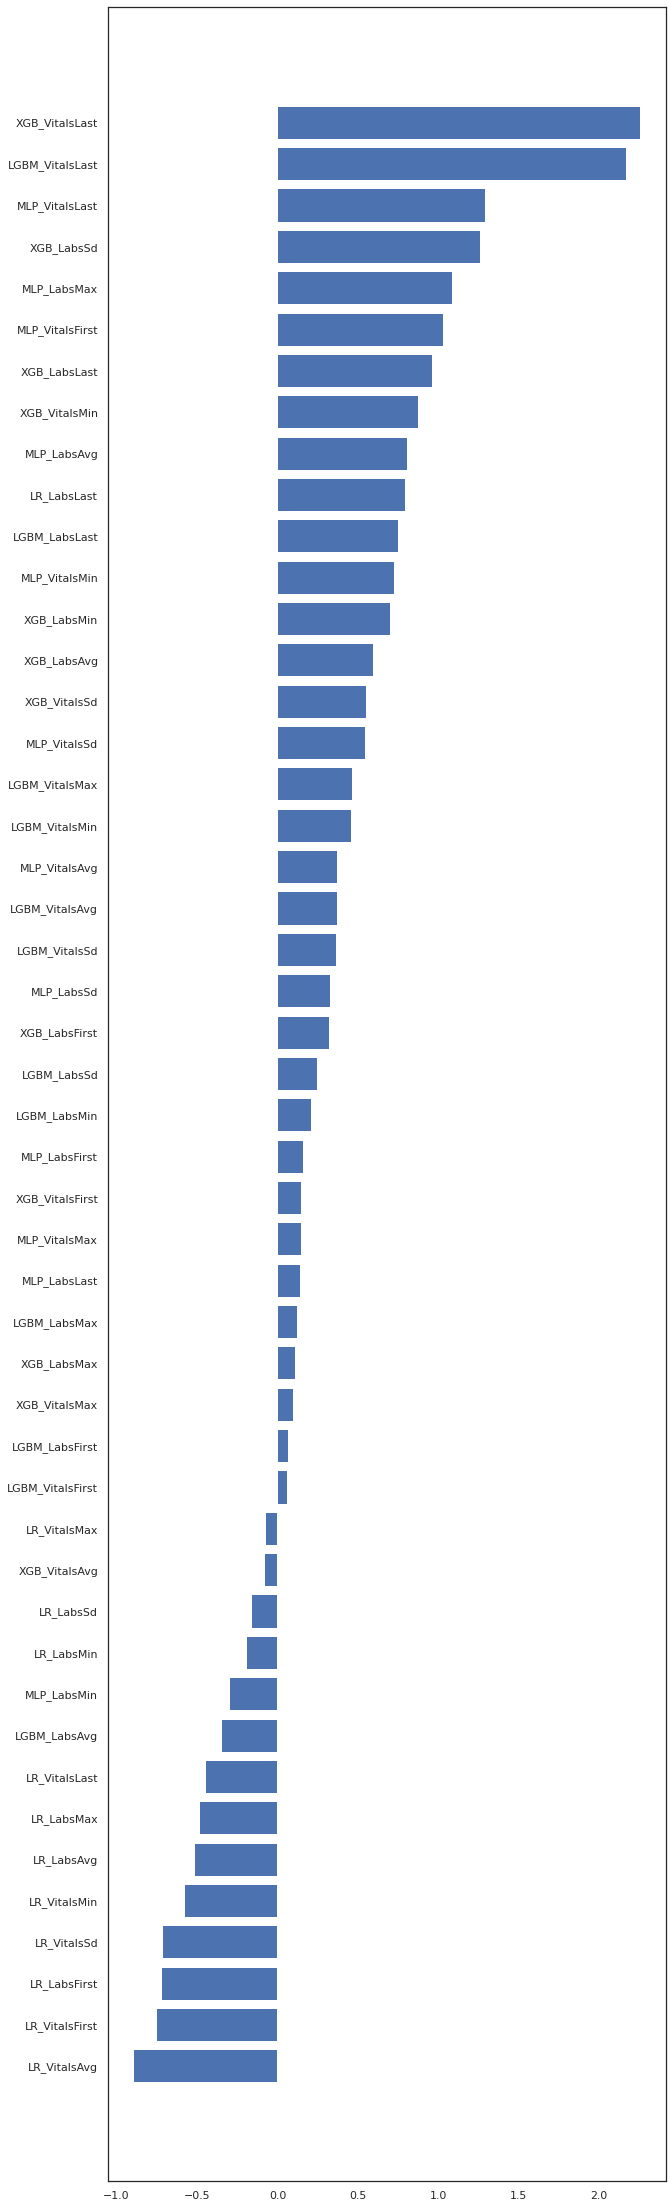

In [40]:
lrDf = pd.DataFrame(data=list(zip(XNewTrain.columns, lr.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Load performance metrics from individual models

In [41]:
import pickle

with open('data/model_scores.p', 'rb') as fp:
    scores_dict = pickle.load(fp)

In [42]:
scores_dict['xgb_ensemble'] = (xgb_prob, xgb_pred, ySevenDayTestTest, xgb_scores)
scores_dict['lr_ensemble'] = (lr_prob, lr_pred, ySevenDayTestTest, lr_scores)

In [43]:
labels = []
preds = {}
ys = {}
accuracy_scores = []
balanced_accuracy_scores = []
average_precision_scores = []
f1_scores = []
roc_auc_scores = []
mccf1_scores = []

for label, (prob, pred, y, scores) in scores_dict.items():
    labels.append(label)
    preds[label] = pred
    ys[label] = y
    for key, value in scores.items():
        if key == 'test_accuracy':
            accuracy_scores.append(value)
        if key == 'test_balanced_accuracy':
            balanced_accuracy_scores.append(value)
        if key == 'test_average_precision':
            average_precision_scores.append(value)
        if key == 'test_f1':
            f1_scores.append(value)
        if key == 'test_mccf1_score':
            mccf1_scores.append(value)
        if key == 'test_roc_auc':
            roc_auc_scores.append(value)

### Accuracy scores

[Text(0, 0.5, 'Model Accuracy')]

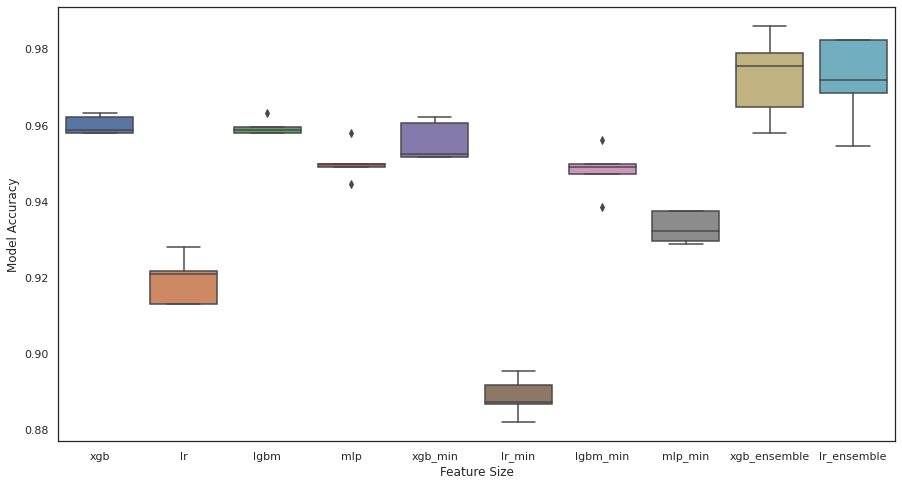

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=accuracy_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Accuracy')

### Balanced accuracy scores

[Text(0, 0.5, 'Model Balanced Accuracy')]

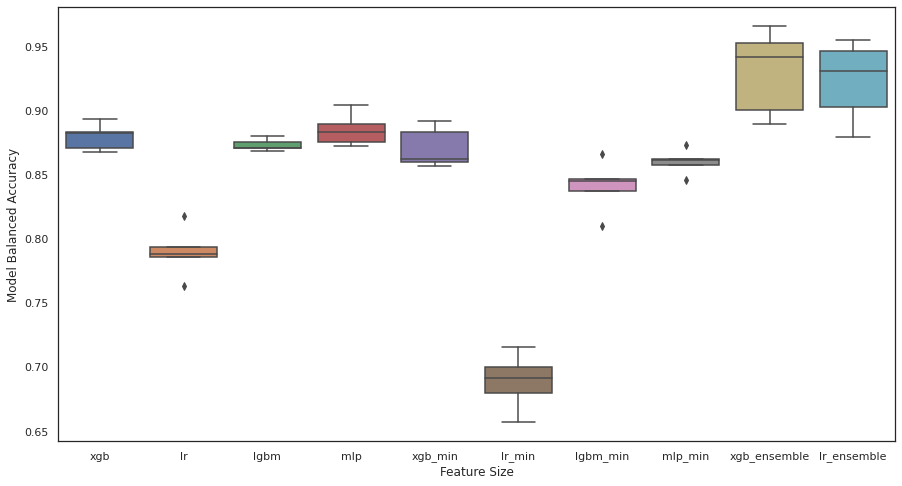

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=balanced_accuracy_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Balanced Accuracy')

### Average Precision scores

[Text(0, 0.5, 'Model Average Precision')]

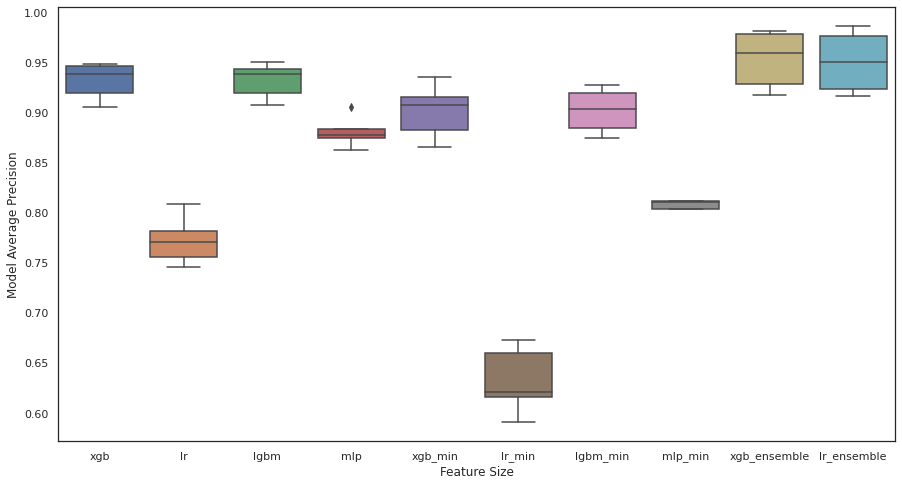

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=average_precision_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Average Precision')

### AUROC scores

[Text(0, 0.5, 'Model AUROC')]

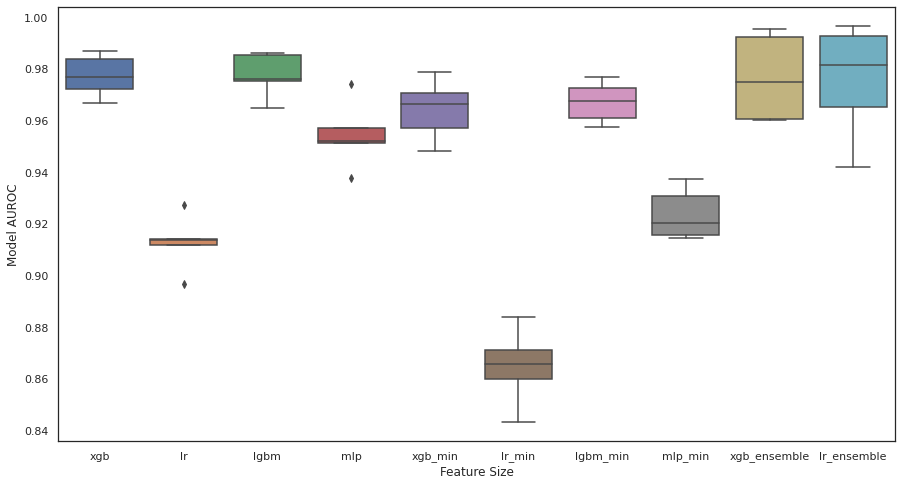

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=roc_auc_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model AUROC')

### F1 scores

[Text(0, 0.5, 'Model F1')]

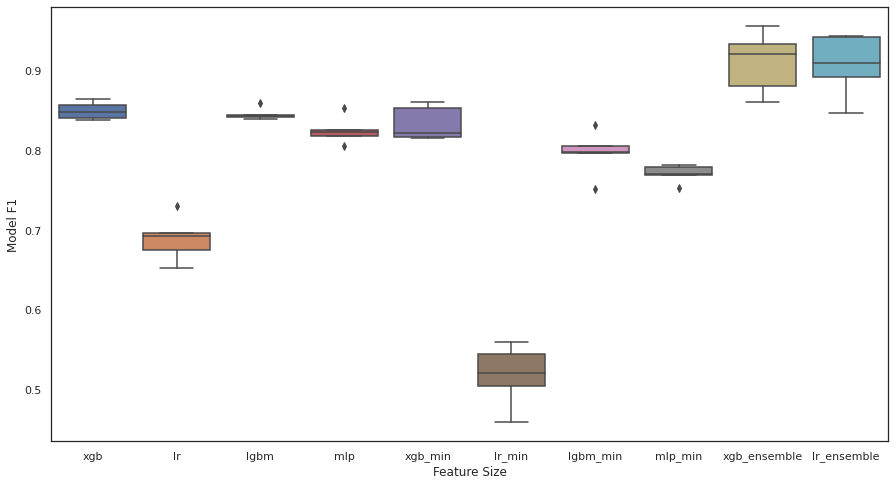

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=f1_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model F1')

### MCCF1

[Text(0, 0.5, 'Model MCCF1')]

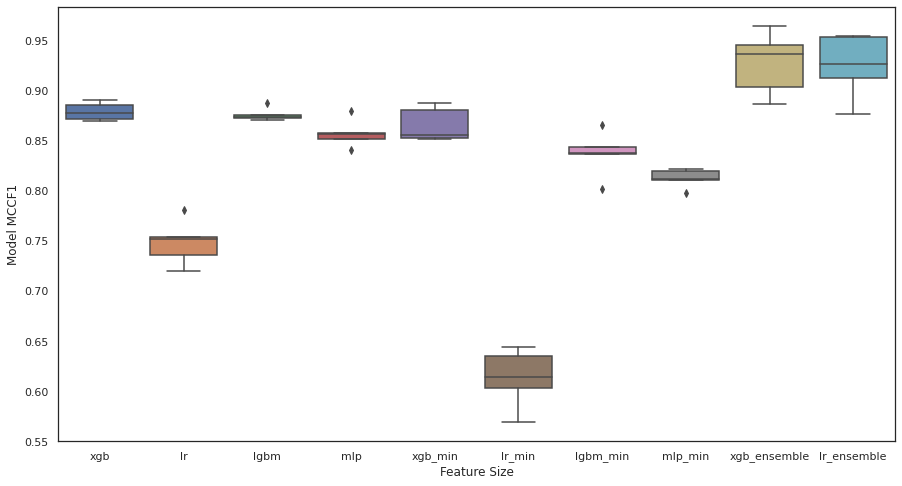

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=mccf1_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model MCCF1')

### Performance metrics table

In [51]:
def calculateScores(pred, y):
    return [
        accuracy_score(pred, y),
        balanced_accuracy_score(pred, y),
        average_precision_score(pred, y),
        f1_score(pred, y),
        matthews_corrcoef(pred, y),
        roc_auc_score(pred, y),
        calculateMccF1(pred, y)
    ]

In [52]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

data = []
data.append(["XGB"] + calculateScores(preds["xgb"], ySevenDayTest))
data.append(["LR"] + calculateScores(preds["lr"], ySevenDayTest))
data.append(["LGBM"] + calculateScores(preds["lgbm"], ySevenDayTest))
data.append(["MLP"] + calculateScores(preds["mlp"], ySevenDayTest))
data.append(["XGB_MIN"] + calculateScores(preds["xgb_min"], ySevenDayTest))
data.append(["LR_MIN"] + calculateScores(preds["lr_min"], ySevenDayTest))
data.append(["LGBM_MIN"] + calculateScores(preds["lgbm_min"], ySevenDayTest))
data.append(["MLP_MIN"] + calculateScores(preds["mlp_min"], ySevenDayTest))
data.append(["XGB_ENSEMBLE"] + calculateScores(preds["xgb_ensemble"], ySevenDayTestTest))
data.append(["LR_ENSEMBLE"] + calculateScores(preds["lr_ensemble"], ySevenDayTestTest))

perfromanceDf = pd.DataFrame(data, columns=["Label", "Accuracy", "Balanced Accuracy", "Average Precision", "F1", "MCC", "ROC", "MCCF1"])
perfromanceDf

,Label,Accuracy,Balanced Accuracy,Average Precision,F1,MCC,ROC,MCCF1
0,XGB,0.971851,0.977271,0.829149,0.906542,0.894005,0.977271,0.924029
1,LR,0.918367,0.871328,0.553172,0.722488,0.680436,0.871328,0.773568
2,LGBM,0.973258,0.980218,0.836993,0.911215,0.899524,0.980218,0.927866
3,MLP,0.949331,0.919380,0.720478,0.837104,0.808337,0.919380,0.866361
4,XGB_MIN,0.962702,0.948279,0.785802,0.879271,0.858936,0.948279,0.901131
5,LR_MIN,0.882477,0.822796,0.334208,0.534819,0.500937,0.822796,0.626731
6,LGBM_MIN,0.957072,0.959151,0.742010,0.853012,0.835603,0.959151,0.880916
7,MLP_MIN,0.957072,0.959151,0.742010,0.853012,0.835603,0.959151,0.880916
8,XGB_ENSEMBLE,0.971930,0.955536,0.841060,0.911111,0.894766,0.955536,0.926960
9,LR_ENSEMBLE,0.975439,0.975510,0.851865,0.919540,0.907190,0.975510,0.934322
